# Livrable 3

## 1. Introduction

Dans le cadre du projet **Leyenda**, l'objectif de ce livrable est de développer un système automatique capable de générer des légendes descriptives pour des photographies, en utilisant des techniques avancées d'apprentissage profond. Ce livrable s'appuie sur l'un des datasets de référence dans le domaine, **MS COCO**, qui contient des images annotées manuellement avec des descriptions textuelles détaillées.

Pour accomplir cette tâche, nous avons conçu un modèle de **réseau de neurones convolutionnel (CNN)** couplé à un **réseau de neurones récurrent (RNN)**. Le CNN est utilisé pour extraire les caractéristiques visuelles des images, tandis que le RNN, notamment un **modèle de type LSTM (Long Short-Term Memory)**, traite ces caractéristiques pour générer des séquences de mots, formant ainsi des légendes.

Le modèle suit un pipeline en plusieurs étapes, commençant par le prétraitement des images et des légendes textuelles, suivi de l'entraînement du modèle à partir des données étiquetées. Ce document détaille les différentes phases de développement, l'architecture du modèle, ainsi que les résultats obtenus lors des phases de test. 

L'objectif final de ce livrable est de présenter une solution automatisée, capable d'être déployée pour une utilisation dans des environnements réels, où elle pourrait analyser de nouvelles images et générer des légendes précises, en s'appuyant sur l'expérience acquise lors de l'entraînement sur MS COCO.

## 2. Importation et exploration des données

### 2.1. Code d'importation

Pour la réalisation de ce projet de captioning d'images, plusieurs librairies sont nécessaires afin de gérer les différentes étapes du traitement des données, de l'entraînement du modèle et de la visualisation des résultats.

In [1]:
import os, zipfile, random, json, collections, urllib, time

import numpy as np
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt

2024-10-24 08:55:42.015172: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-24 08:55:42.023207: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 08:55:42.031951: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 08:55:42.034399: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-24 08:55:42.041071: I tensorflow/core/platform/cpu_feature_guar

### 2.2. Configuration et initialisation des répertoires et paramètres

Comme pour les autres Livrables, nous commençont par définir des chemins pour organiser les fichiers et dossiers d'un projet, puis crée les répertoires s'ils n'existent pas déjà. 

In [2]:
project_path = os.getcwd()

paths = {
    "data_dir": f"{project_path}/data",
    "train_images_dir": f"{project_path}/data/train2014",
    "annotations_dir": f"{project_path}/data/annotations",
    "train_images_zip": f"{project_path}/data/train2014.zip",
    "annotations_zip": f"{project_path}/data/annotations_trainval2014.zip",
    "annotation_file": f"{project_path}/data/annotations/captions_train2014.json",
    "tokenizer_file": f"{project_path}/tokenizer.json",
    "checkpoints_path": f"{project_path}/checkpoints",
    "models_path": f"{project_path}/models",
}

if not os.path.exists(paths["data_dir"]):
    os.makedirs(paths["data_dir"])

if not os.path.exists(paths["checkpoints_path"]):
    os.makedirs(paths["checkpoints_path"])

if not os.path.exists(paths["models_path"]):
    os.makedirs(paths["models_path"])

COCO_URLs = {
    "images": "http://images.cocodataset.org/zips/train2014.zip",
    "annotations": "http://images.cocodataset.org/annotations/annotations_trainval2014.zip"
}

#### 2.3. Paramètres du modèle

Dans cette section, nous définissons plusieurs hyperparamètres essentiels pour l'entraînement du modèle de captioning d'images. Ces hyperparamètres contrôlent différents aspects du modèle et de son processus d'apprentissage.


In [3]:
epochs = 100
batch_size = 32
buffer_size = 1000

embedding_dim = 256

units = 512

top_k = 10000
vocab_size = top_k + 1

features_shape = 2048
attention_features_shape = 64

epoch_var = tf.Variable(0, name='epoch', dtype=tf.int64)

I0000 00:00:1729760145.835530    4064 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729760145.842558    4064 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729760145.842585    4064 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729760145.844215    4064 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729760145.844239    4064 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0


- **`epochs`** : Définit le nombre total d'**époques d'entraînement**. Une époque correspond à un passage complet de l'ensemble de données à travers le modèle. Nous avons fixé ce nombre à `100` pour permettre au modèle de voir suffisamment de données pour apprendre efficacement.

- **`batch_size`** : Nombre d'exemples d'entraînement traités à la fois pendant l'entraînement. Ici, nous utilisons des batches de taille `32`, ce qui signifie que le modèle ajuste ses poids après avoir traité 32 exemples d'images et leurs légendes. Un batch plus grand peut accélérer l'entraînement mais nécessite plus de mémoire GPU.

- **`buffer_size`** : Ce paramètre détermine la taille du **buffer de mélange** utilisé lors de la création du dataset TensorFlow. Un buffer de `1000` permet un mélange aléatoire des exemples pour éviter les corrélations entre les données d'entraînement et améliorer la généralisation du modèle.

- **`embedding_dim`** : Dimension des vecteurs d'**embedding** pour les mots dans les légendes. Les embeddings transforment chaque mot en un vecteur dense de taille `256`, qui capture des informations sémantiques. Plus la dimension est grande, plus le modèle peut capturer des relations complexes entre les mots, mais cela augmente aussi le temps de calcul.

- **`units`** : Nombre d'unités dans la **LSTM** (Long Short-Term Memory) du décodeur. Avec `512` unités, nous avons une mémoire cachée de grande capacité pour stocker l'information à long terme pendant la génération des légendes.

- **`top_k`** : Ce paramètre limite le vocabulaire aux `10 000` mots les plus fréquents dans le dataset d'entraînement. Cela réduit la complexité du modèle en excluant les mots rares qui n'ont pas d'impact significatif sur la performance globale.

- **`vocab_size`** : Taille totale du vocabulaire, fixée à `top_k + 1` pour inclure les mots les plus fréquents et des tokens spéciaux comme `<pad>`, `<start>`, et `<end>`.

- **`features_shape`** : Taille des **caractéristiques visuelles** extraites par le modèle CNN (InceptionV3). Ce nombre, `2048`, correspond aux dimensions des vecteurs caractéristiques produits par le modèle de CNN, qui capture les informations importantes des images.

- **`attention_features_shape`** : Taille des caractéristiques d'attention utilisée pour modéliser l'importance des différentes parties d'une image. Ici, nous fixons cette valeur à `64`.

- **`epoch_var`** : Variable TensorFlow qui garde la trace de l'époque actuelle pendant l'entraînement. Cela permet de reprendre l'entraînement à partir du dernier point sauvegardé si nécessaire.

### 2.4. Téléchargement et extraction des données COCO

L’un des prérequis essentiels pour entraîner un modèle de captioning est de disposer d'un dataset riche en images et légendes correspondantes. Dans ce projet, nous utilisons le dataset COCO 2014 qui contient un grand nombre d’images d’entraînement et des annotations sous forme de légendes textuelles. Ce bloc de code permet de gérer automatiquement le téléchargement et l'extraction de ces données dans l'environnement de travail.

In [4]:
def download_and_extract(zip_path, extract_dir, url, description):
    # Download the zip file if it's not already present
    if not os.path.exists(zip_path):
        print(f"Downloading COCO {description} dataset...")
        urllib.request.urlretrieve(url, zip_path)
        print(f"Download of {description} completed.")
    else:
        print(f"The zip file for {description} already exists.")

    # Check and extract if necessary
    if not os.path.exists(extract_dir):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            print(f"Extracting {description} files...")
            zip_ref.extractall(os.path.dirname(extract_dir))
            print(f"Extraction of {description} completed.")
    else:
        print(f"The {description} files have already been extracted.")

    # Display the number of extracted files
    if os.path.exists(extract_dir):
        extracted_files = os.listdir(extract_dir)
        print(f"{len(extracted_files)} files extracted in {extract_dir}")
    else:
        print(f"Error: the extraction folder for {description} does not exist.")

# Download and extract the images and annotations by generating the paths on the fly
download_and_extract(
    paths["train_images_zip"],
    paths["train_images_dir"],
    COCO_URLs["images"],
    "images"
)

download_and_extract(
    paths["annotations_zip"],
    paths["annotations_dir"],
    COCO_URLs["annotations"],
    "annotations"
)

The zip file for images already exists.
The images files have already been extracted.
141701 files extracted in /tf/ProjetDeepLearning/livrable_3/data/train2014
The zip file for annotations already exists.
The annotations files have already been extracted.
6 files extracted in /tf/ProjetDeepLearning/livrable_3/data/annotations


### 2.5. Création de la correspondance image-légende

Ce bloc de code a pour objectif de créer une structure de données associant chaque image à ses légendes correspondantes à partir des annotations fournies dans le fichier JSON du dataset COCO. Cela permettra ensuite d’entraîner un modèle de captioning, où chaque image sera liée à une ou plusieurs légendes descriptives.

In [5]:
def create_image_caption_mapping(annotation_file, image_dir):
    # Read the annotation JSON file
    with open(annotation_file, 'r') as f:
        annotations = json.load(f)
    
    # Dictionary to associate each image with its captions
    image_path_to_caption = collections.defaultdict(list)

    # Loop through each annotation
    for annotation in annotations['annotations']:
        # Add start and end tags to each caption
        caption = f"<start> {annotation['caption']} <end>"
        
        # Build the corresponding image path
        image_id = annotation['image_id']
        image_filename = f'COCO_train2014_{image_id:012d}.jpg'
        image_path = os.path.join(image_dir, image_filename)
        
        # Associate the caption with the image
        image_path_to_caption[image_path].append(caption)

    return image_path_to_caption

# Create the image to caption mapping
image_path_to_caption = create_image_caption_mapping(
    paths["annotation_file"], 
    paths["train_images_dir"]
)

### 2.6. Sélection d'images et de légendes aléatoires

Ce bloc de code permet de sélectionner un échantillon aléatoire d'images et leurs légendes associées à partir du dictionnaire d'annotations précédemment généré. Cette étape est utile pour créer un sous-ensemble du dataset complet, souvent nécessaire lorsque l’entraînement est long ou que les ressources sont limitées.

In [6]:
def get_random_image_paths_and_captions(image_path_to_caption, num_samples):
    # Get all the image paths
    image_paths = list(image_path_to_caption.keys())
    
    # Select a random sample of images
    train_image_paths = random.sample(image_paths, num_samples)

    # Initialize lists for captions and duplicated image paths
    train_captions = []
    img_name_vector = []

    # Fill the lists based on the annotations
    for image_path in train_image_paths:
        caption_list = image_path_to_caption[image_path]
        # Add each caption to train_captions
        train_captions.extend(caption_list)
        # Add the image path duplicated according to the number of annotations
        img_name_vector.extend([image_path] * len(caption_list))

    return img_name_vector, train_captions

# Get random image paths and captions
img_name_vector, train_captions = get_random_image_paths_and_captions(image_path_to_caption, 5000)


25017 25017
<start> A man fixing another man's white lapel flower. <end>


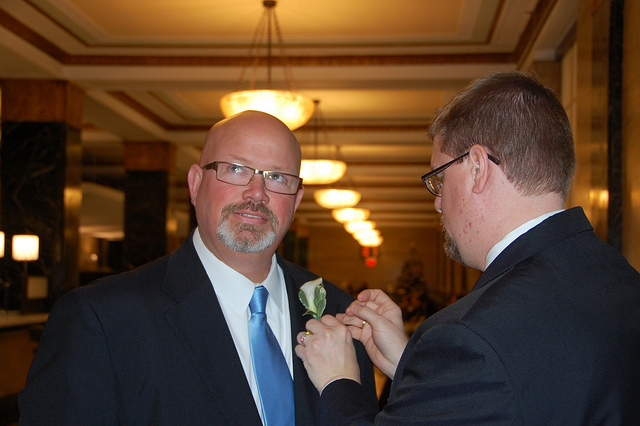

In [7]:
print(len(train_captions), len(img_name_vector))
print(train_captions[0])
Image.open(img_name_vector[0])

### 2.7. Création d’un extracteur de caractéristiques d’images

La fonction `create_image_feature_extractor()` a pour objectif de créer un modèle capable d'extraire les **caractéristiques visuelles** des images en utilisant un réseau de neurones convolutionnel (CNN) pré-entraîné. Plus précisément, elle utilise le modèle **InceptionV3** pré-entraîné sur le dataset **ImageNet**, tout en excluant la couche de classification finale. Ce modèle d'extraction de caractéristiques est utilisé dans le cadre de tâches de génération de légendes d'images (image captioning), où les informations visuelles sont transformées en un vecteur de caractéristiques compact et riche en informations.

In [8]:
def create_image_feature_extractor():
    # Download the pre-trained InceptionV3 model on ImageNet without the top layer
    image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

    # Get the input of the InceptionV3 model
    new_input = image_model.input

    # Get the output of the last hidden (dense) layer
    hidden_layer = image_model.layers[-1].output

    # Create a new model that extracts dense features from images
    image_features_extract_model = tf.keras.Model(inputs=new_input, outputs=hidden_layer)

    return image_features_extract_model

# Create the image feature extractor model
image_features_extract_model = create_image_feature_extractor()

### 2.8. Prétraitement et extraction des caractéristiques des image

L'objectif de ce bloc de code est de prétraiter les images, d’extraire leurs caractéristiques à l'aide du modèle InceptionV3, et de sauvegarder ces caractéristiques sous forme de fichiers .npy pour une utilisation ultérieure dans le modèle de captioning.

In [9]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    return img, image_path

def save_image_features(batch_features, paths):
    for bf, p in zip(batch_features, paths):
        path_of_feature = p.numpy().decode("utf-8")

        np.save(path_of_feature, bf.numpy())

# Preprocess the images
encode_train = sorted(set(img_name_vector))

# Create a TensorFlow Dataset to process the images in batches
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

# Loop through the dataset batch by batch to extract image features
for img, path in tqdm(image_dataset):
    # Extract the features of the current batch using InceptionV3
    batch_features = image_features_extract_model(img)
    # Reshape the features from (16, 8, 8, 2048) to (16, 64, 2048)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
    # Save the extracted features for each image in the batch
    save_image_features(batch_features, path)


  0%|          | 0/313 [00:00<?, ?it/s]2024-10-24 08:55:49.569526: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906
W0000 00:00:1729760149.606308    4064 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729760149.640496    4064 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729760149.641118    4064 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729760149.644548    4064 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729760149.645714    4064 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729760149.646377    4064 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729760149.666513    4064 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W000

### 2.9. Prétraitement des légendes et sauvegarde du tokenizer

Ce bloc de code s’occupe de convertir les légendes d’entraînement en séquences de tokens, de les normaliser à une longueur commune, et de sauvegarder le tokenizer pour une utilisation ultérieure. Ce processus est essentiel pour préparer les légendes dans un format compréhensible par un modèle de machine learning. Un tokenizer en deep learning est un outil qui convertit du texte brut en une séquence de tokens, généralement des mots ou des sous-mots, afin de préparer les données pour l'entraînement des modèles. Il attribue des identifiants numériques à chaque token, permettant ainsi aux modèles de traiter et d'analyser efficacement le langage naturel.

In [10]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

def preprocess_captions(train_captions, top_k=5000):
    # Initialize the tokenizer with specific parameters
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=top_k, 
        oov_token="<unk>", 
        filters=r'!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '
    )
    
    # Build the vocabulary based on the captions
    tokenizer.fit_on_texts(train_captions)

    # Add a special token to pad short captions
    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'

    # Convert the captions into sequences of tokens
    train_seqs = tokenizer.texts_to_sequences(train_captions)

    # Pad the sequences to the maximum length
    cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

    # Calculate the maximum length of the sequences
    max_length = calc_max_length(train_seqs)

    return cap_vector, tokenizer, max_length

def save_tokenizer(tokenizer, save_path):
    tokenizer_json = tokenizer.to_json()
    with open(save_path, 'w', encoding='utf-8') as f:
        f.write(json.dumps(tokenizer_json, ensure_ascii=False))
    print(f'Tokenizer saved to {save_path}.')

# Preprocess the training captions
cap_vector, tokenizer, max_length = preprocess_captions(train_captions, top_k)

# Save the tokenizer for later use
tokenizer_save_path = paths["tokenizer_file"]
save_tokenizer(tokenizer, tokenizer_save_path)


Tokenizer saved to /tf/ProjetDeepLearning/livrable_3/tokenizer.json.


### 2.10. Création de la correspondance image-légende et division du dataset

L’objectif de ce segment de code est de créer une structure de données qui associe chaque image à ses légendes correspondantes, puis de diviser le dataset en ensembles d’entraînement et de validation. Cette étape est essentielle pour évaluer les performances du modèle tout en évitant le surapprentissage.

In [11]:
def create_image_caption_mapping(img_name_vector, cap_vector):
    img_to_cap_vector = collections.defaultdict(list)
    for img, cap in zip(img_name_vector, cap_vector):
        img_to_cap_vector[img].append(cap)
    
    return img_to_cap_vector

def split_dataset(img_to_cap_vector, split_ratio=0.8):
    # Retrieve the keys (image paths, without duplicates)
    img_keys = list(img_to_cap_vector.keys())
    random.shuffle(img_keys)  # Shuffle the keys

    # Split the indices according to the defined ratio
    slice_index = int(len(img_keys) * split_ratio)
    img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

    # Build the training and validation lists
    img_name_train, cap_train = [], []
    img_name_val, cap_val = [], []

    # Loop for the training set
    for imgt in img_name_train_keys:
        capt_len = len(img_to_cap_vector[imgt])
        img_name_train.extend([imgt] * capt_len)
        cap_train.extend(img_to_cap_vector[imgt])

    # Loop for the validation set
    for imgv in img_name_val_keys:
        capv_len = len(img_to_cap_vector[imgv])
        img_name_val.extend([imgv] * capv_len)
        cap_val.extend(img_to_cap_vector[imgv])

    return img_name_train, cap_train, img_name_val, cap_val

# Associate images with their captions
img_to_cap_vector = create_image_caption_mapping(img_name_vector, cap_vector)

# Split the dataset into training and validation sets
img_name_train, cap_train, img_name_val, cap_val = split_dataset(img_to_cap_vector, split_ratio=0.8)

# Display the sizes of the training and validation sets
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

num_steps = len(img_name_train) // batch_size

### 2.11. Création du dataset d'entraînement avec préchargement des caractéristiques

Ce code gère la création d’un dataset TensorFlow à partir des chemins d’images et de leurs légendes. Les images ne sont pas directement chargées mais plutôt leurs caractéristiques extraites (sous forme de fichiers .npy), préalablement générées à l’aide du modèle InceptionV3.

In [12]:
def map_func(img_name, cap):
    img_path = img_name.decode('utf-8') + '.npy'
    if os.path.exists(img_path):
        img_tensor = np.load(img_path)
    else:
        raise FileNotFoundError(f"The file {img_path} does not exist.")
    
    return img_tensor, cap

def create_dataset(img_names, captions, batch_size=batch_size, buffer_size=buffer_size):
    # Create the dataset from the images and captions
    dataset = tf.data.Dataset.from_tensor_slices((img_names, captions))

    # Use map to load the numpy files
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
        map_func, [item1, item2], [tf.float32, tf.int32]),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Shuffle the data and divide into batches
    dataset = dataset.shuffle(buffer_size).batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

# Create the training dataset
dataset = create_dataset(img_name_train, cap_train)

## 3. Le modèle

### 3.1. Classe : CNN_Encoder

La classe CNN_Encoder est un encodeur d'images conçu pour transformer les caractéristiques extraites des images en une représentation adaptée à l'entrée dans un modèle séquentiel, tel qu'un réseau de neurones récurrent (RNN). Dans ce cas, les caractéristiques des images sont déjà extraites par InceptionV3 et ne nécessitent pas un traitement supplémentaire complexe. L'encodeur agit simplement comme un intermédiaire en réduisant la dimensionnalité et en appliquant une couche dense avec activation ReLU et un Dropout pour régulariser l'apprentissage.

In [13]:
@tf.keras.utils.register_keras_serializable(package="MyCustomModels")
class CNN_Encoder(tf.keras.Model):
    # Since the images are already preprocessed by InceptionV3 and represented in compact form,
    # the CNN encoder will only pass these features through a dense layer
    def __init__(self, embedding_dim, dropout_rate=0.5):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        x = self.dropout(x)
        return x

### 3.2. Classe : BahdanauAttention

La classe BahdanauAttention implémente le mécanisme d'attention proposé par Bahdanau et al. en 2015. L'attention permet au modèle de se concentrer sur certaines parties des données d'entrée (dans ce cas, les caractéristiques des images) en fonction de l'état caché courant du décodeur (par exemple, un RNN ou un LSTM). Cela améliore l'apprentissage en pondérant différemment les caractéristiques en fonction de leur pertinence pour générer la légende à chaque étape.

In [14]:
@tf.keras.utils.register_keras_serializable(package="MyCustomModels")
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units, dropout_rate=0.5):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, features, hidden, training=False):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        attention_hidden_layer = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        score = self.V(attention_hidden_layer)

        attention_weights = tf.nn.softmax(score, axis=1)
        attention_weights = self.dropout(attention_weights, training=training)

        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

### 3.3 Classe : RNN_Decoder

La classe RNN_Decoder implémente un décodeur basé sur un réseau de neurones récurrents (RNN), plus précisément un LSTM (Long Short-Term Memory), utilisé pour générer des séquences de texte à partir de caractéristiques d'images extraites et du vecteur de contexte fourni par un mécanisme d'attention. Cette classe fait partie d'un modèle de captioning d'images.

In [15]:
@tf.keras.utils.register_keras_serializable(package="MyCustomModels")
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        
        # Replacing the GRU layer with LSTM
        self.lstm = tf.keras.layers.LSTM(
            self.units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer='glorot_uniform'
        )

        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden[0])

        # Passing the current word to the embedding layer
        x = self.embedding(x)
        
        # Concatenating the context vector and the embedding
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # Passing the concatenated vector to the LSTM
        output, hidden_state, cell_state = self.lstm(x, initial_state=hidden)

        # Dense layer after LSTM
        y = self.fc1(output)

        # Reshaping the result
        y = tf.reshape(y, (-1, y.shape[2]))

        # Final dense layer to obtain the vocabulary prediction
        y = self.fc2(y)

        return y, [hidden_state, cell_state], attention_weights

    def reset_state(self, batch_size):
        # For LSTM, initialize two states: hidden state and cell state
        return [tf.zeros((batch_size, self.units)), tf.zeros((batch_size, self.units))]

### 3.4. Création de l'encodeur

In [16]:
# Creating the encoder
encoder = CNN_Encoder(embedding_dim)

### 3.5. Création du décodeur

In [17]:
# Creating the decoder
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

### 3.6. Optimiseur et fonction de perte

Ces éléments jouent un rôle clé dans la phase d'entraînement du modèle de captioning. L'optimiseur ajuste les poids du modèle pour minimiser la perte, et la fonction de perte mesure la différence entre les prédictions du modèle et les légendes réelles.

In [18]:
# Adam optimizer
optimizer = tf.keras.optimizers.Adam()

# Loss function
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


### 3.7. Gestion des checkpoints

Ce code permet de sauvegarder et de restaurer l'état du modèle à différents points pendant l'entraînement. Les checkpoints contiennent les poids du modèle (pour l'encodeur et le décodeur), ainsi que l'état de l'optimiseur, ce qui permet de reprendre l'entraînement à partir du dernier point de sauvegarde en cas d'interruption.

In [19]:
def setup_checkpoint(encoder, decoder, optimizer, epoch_var, max_to_keep=5):
    ckpt = tf.train.Checkpoint(
        encoder=encoder,
        decoder=decoder,
        optimizer=optimizer,
        epoch=epoch_var
    )
    
    ckpt_manager = tf.train.CheckpointManager(
        ckpt,
        paths["checkpoints_path"],
        max_to_keep=max_to_keep
    )
    
    # Restore the latest checkpoint if it exists
    if ckpt_manager.latest_checkpoint:
        ckpt.restore(ckpt_manager.latest_checkpoint)
        start_epoch = epoch_var.numpy()
        print(f"Restoring the latest checkpoint at epoch {start_epoch}.")
    else:
        start_epoch = 0
        print("No checkpoint found, training from scratch.")
    
    return ckpt_manager, start_epoch

# Set up checkpoints
ckpt_manager, start_epoch = setup_checkpoint(encoder, decoder, optimizer, epoch_var)


No checkpoint found, training from scratch.


### 3.8. Fonction : train_step

La fonction train_step représente une étape unique d'entraînement du modèle, où une image et sa légende cible sont traitées pour mettre à jour les poids du modèle. Cette étape comprend la propagation avant (encodage des images, génération des légendes), le calcul de la perte, et la rétropropagation pour ajuster les poids à l'aide des gradients.

In [20]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # Initialize the hidden state for each batch
    hidden = decoder.reset_state(batch_size=target.shape[0])

    # Initialize the decoder input with the <start> token for each sequence
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:  # Compute gradients to optimize model weights
        # Encode the image (extract features with the encoder)
        features = encoder(img_tensor)

        # Loop through each step of the sequence (each word)
        for i in range(1, target.shape[1]):
            # Predict the i-th word with the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            # Calculate loss for this step (comparison between the truth and the prediction)
            loss += loss_function(target[:, i], predictions)

            # The correct word is used as input for the next prediction
            dec_input = tf.expand_dims(target[:, i], 1)

    # Calculate the average loss per sequence
    total_loss = loss / int(target.shape[1])

    # List of trainable variables (encoder and decoder)
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    # Compute gradients based on the loss
    gradients = tape.gradient(loss, trainable_variables)
    
    # Apply gradients to update the model weights
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss


### 3.9. Fonction : train_model()

La fonction train_model() exécute l'entraînement du modèle de captioning d'images sur un nombre spécifié d'époques. À chaque époque, elle parcourt le dataset d'entraînement, met à jour les poids du modèle à l'aide des gradients, et sauvegarde les checkpoints périodiquement. Cette fonction affiche également la progression et le temps d'exécution pour chaque époque.

In [21]:
def train_model(epochs, start_epoch, dataset, num_steps, ckpt_manager, epoch_var):
    loss_plot = []

    for epoch in range(start_epoch, epochs):
        start = time.time()
        total_loss = 0

        # Update epoch_var
        epoch_var.assign(epoch + 1)

        # Progress bar for the current epoch
        with tqdm(total=num_steps, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch") as pbar:

            # Iterate over training batches
            for batch, (img_tensor, target) in enumerate(dataset):
                # Perform a training step
                batch_loss, t_loss = train_step(img_tensor, target)
                total_loss += t_loss

                # Update the progress bar
                pbar.set_postfix({"Batch Loss": f"{batch_loss.numpy() / int(target.shape[1]):.4f}"})
                pbar.update(1)

            # Save the average loss for the epoch
            loss_plot.append(total_loss / num_steps)

            # Save checkpoints every 5 epochs
            if (epoch + 1) % 5 == 0:
                ckpt_manager.save()
                print(f'Checkpoint saved at epoch {epoch + 1}')

        # Display the average loss and time taken for the epoch
        print(f'\nEpoch {epoch + 1} Loss {total_loss / num_steps:.6f}')
        print(f'Time taken for epoch {epoch + 1}: {time.time() - start:.2f} seconds\n')

    return loss_plot

# Start the training
loss_plot = train_model(epochs, start_epoch, dataset, num_steps, ckpt_manager, epoch_var)


Epoch 1/15: 626batch [01:24,  1.34s/batch, Batch Loss=0.8164]                      2024-10-24 08:58:37.651935: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 1/15: 626batch [01:24,  7.42batch/s, Batch Loss=0.8164]



Epoch 1 Loss 1.033960
Time taken for epoch 1: 84.38 seconds



Epoch 2/15: 626batch [00:59, 10.44batch/s, Batch Loss=0.7392]                      



Epoch 2 Loss 0.766360
Time taken for epoch 2: 59.96 seconds



Epoch 3/15: 100%|██████████| 625/625 [00:59<00:00, 10.58batch/s, Batch Loss=0.5948]2024-10-24 09:00:36.876063: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 3/15: 626batch [00:59, 10.56batch/s, Batch Loss=0.5948]                      



Epoch 3 Loss 0.666889
Time taken for epoch 3: 59.27 seconds



Epoch 4/15: 626batch [00:59, 10.60batch/s, Batch Loss=0.5472]                      



Epoch 4 Loss 0.599540
Time taken for epoch 4: 59.08 seconds



Epoch 5/15: 626batch [00:58, 10.67batch/s, Batch Loss=0.4923]                      


Checkpoint saved at epoch 5

Epoch 5 Loss 0.542704
Time taken for epoch 5: 58.66 seconds



Epoch 6/15: 626batch [00:59, 10.61batch/s, Batch Loss=0.5262]                      



Epoch 6 Loss 0.489244
Time taken for epoch 6: 59.00 seconds



Epoch 7/15: 100%|██████████| 625/625 [00:58<00:00, 11.71batch/s, Batch Loss=0.4627]2024-10-24 09:04:32.366792: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 7/15: 626batch [00:58, 10.66batch/s, Batch Loss=0.4627]                      



Epoch 7 Loss 0.438643
Time taken for epoch 7: 58.75 seconds



Epoch 8/15: 626batch [00:59, 10.44batch/s, Batch Loss=0.4303]                      



Epoch 8 Loss 0.390052
Time taken for epoch 8: 59.95 seconds



Epoch 9/15: 626batch [00:58, 10.61batch/s, Batch Loss=0.3961]                      



Epoch 9 Loss 0.343562
Time taken for epoch 9: 58.98 seconds



Epoch 10/15: 626batch [01:00, 10.33batch/s, Batch Loss=0.2816]                      


Checkpoint saved at epoch 10

Epoch 10 Loss 0.299746
Time taken for epoch 10: 60.63 seconds



Epoch 11/15: 626batch [00:59, 10.61batch/s, Batch Loss=0.2209]                      



Epoch 11 Loss 0.261658
Time taken for epoch 11: 59.01 seconds



Epoch 12/15: 626batch [00:56, 11.00batch/s, Batch Loss=0.2347]                      



Epoch 12 Loss 0.226985
Time taken for epoch 12: 56.89 seconds



Epoch 13/15: 626batch [00:58, 10.68batch/s, Batch Loss=0.1821]                      



Epoch 13 Loss 0.199002
Time taken for epoch 13: 58.62 seconds



Epoch 14/15: 626batch [00:58, 10.64batch/s, Batch Loss=0.1748]                      



Epoch 14 Loss 0.175723
Time taken for epoch 14: 58.82 seconds



Epoch 15/15: 100%|██████████| 625/625 [01:00<00:00, 10.96batch/s, Batch Loss=0.1509]2024-10-24 09:12:25.343468: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 15/15: 626batch [01:01, 10.25batch/s, Batch Loss=0.1509]                      

Checkpoint saved at epoch 15

Epoch 15 Loss 0.157747
Time taken for epoch 15: 61.07 seconds



### 3.10. Save models

In [22]:
encoder.save(os.path.join(paths["models_path"], 'encoder_livrable_3.model.keras'))
decoder.save(os.path.join(paths["models_path"], 'decoder_livrable_3.model.keras'))

### 3.11. Fonction : plot_metrics()

La fonction plot_metrics() est utilisée pour tracer la courbe de la perte d'entraînement au fil des époques. Bien que dans cet exemple seule la perte soit tracée, la fonction est conçue pour permettre l'ajout d'autres courbes, comme la précision ou le score BLEU, si nécessaire.

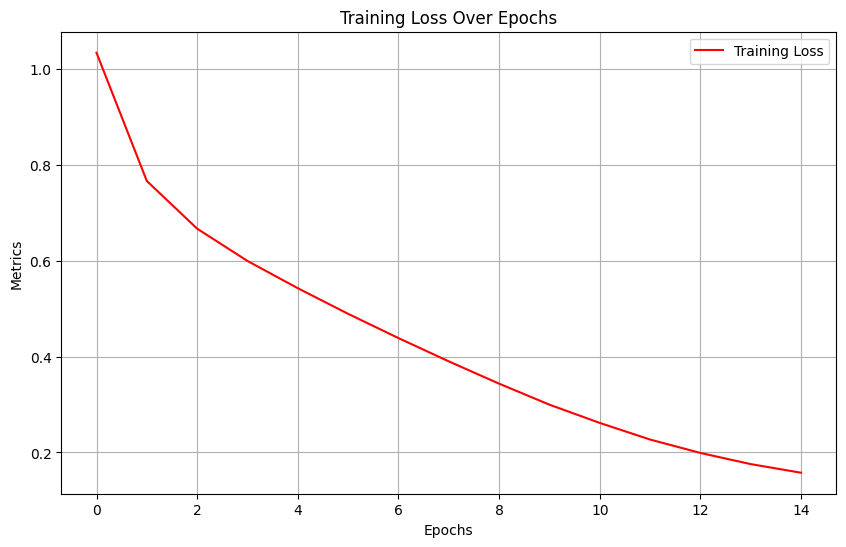

In [23]:
def plot_metrics(loss_plot):
    plt.figure(figsize=(10, 6))
    
    # Plot the loss curve
    plt.plot(loss_plot, label='Training Loss', color='r')
    
    # Add titles and labels
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.title('Training Loss Over Epochs')

    # Add a grid for better readability
    plt.grid(True)

    # Add the legend
    plt.legend()

    # Show the plot
    plt.show()

# Call the function to display the curves
plot_metrics(loss_plot)


## 4. Test

L’objectif final est d’évaluer et tester notre modèle à partir de nouvelles images inconnues. Tout d’abord, nous évaluons notre modèle en utilisant la fonction evaluate. Cette fonction prend une image en entrée, la pré-traite, et passe les caractéristiques extraites à travers l’encodeur et le décodeur pour générer une légende prédite.

In [24]:
def evaluate(image):
    # Initialize the attention plot with zeros
    attention_plot = np.zeros((max_length, attention_features_shape))

    # Reset the hidden state for the decoder
    hidden = decoder.reset_state(batch_size=1)

    # Load and preprocess the image
    temp_input = tf.expand_dims(load_image(image)[0], 0)  # Load the image and add a batch dimension
    img_tensor_val = image_features_extract_model(temp_input)  # Extract features from the image
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    # Pass the image features to the encoder
    features = encoder(img_tensor_val)

    # Initialize the decoder input with the <start> token
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        # Predict the next word
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        # Save the attention weights
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        # Get the predicted word ID and append it to the result
        predicted_id = tf.argmax(predictions, axis=-1).numpy()[0]
        result.append(tokenizer.index_word.get(predicted_id, '<unk>'))  # Use '<unk>' for unknown words

        # Check if the predicted word is <end>
        if tokenizer.index_word.get(predicted_id) == '<end>':
            attention_plot = attention_plot[:len(result), :]  # Trim attention plot to the length of the result
            return result, attention_plot

        # Update the input for the next word
        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]  # Trim the attention plot to the length of the result
    return result, attention_plot

def plot_attention(image, result, attention_plot):

    temp_image = np.array(Image.open(image))
    fig = plt.figure(figsize=(10, 10))
    len_result = len(result)
    grid_size = int(np.ceil(np.sqrt(len_result)))

    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(grid_size, grid_size, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()


Ensuite, nous visualisons les poids d’attention pour chaque mot prédit afin de mieux comprendre quelles parties de l’image influencent chaque mot. Pour ce faire, nous utilisons la fonction display_random_annotation qui sélectionne aléatoirement une image et sa légende réelle, puis génère une légende prédite avec notre modèle. Nous affichons ensuite la légende réelle et la légende prédite, ainsi que la visualisation des poids d’attention.


Image ID: 1258
Real Caption: <start> a tennis player running on a court with a racket <end>
Prediction Caption: a man reaching to hit a tennis ball on a tennis court <end>


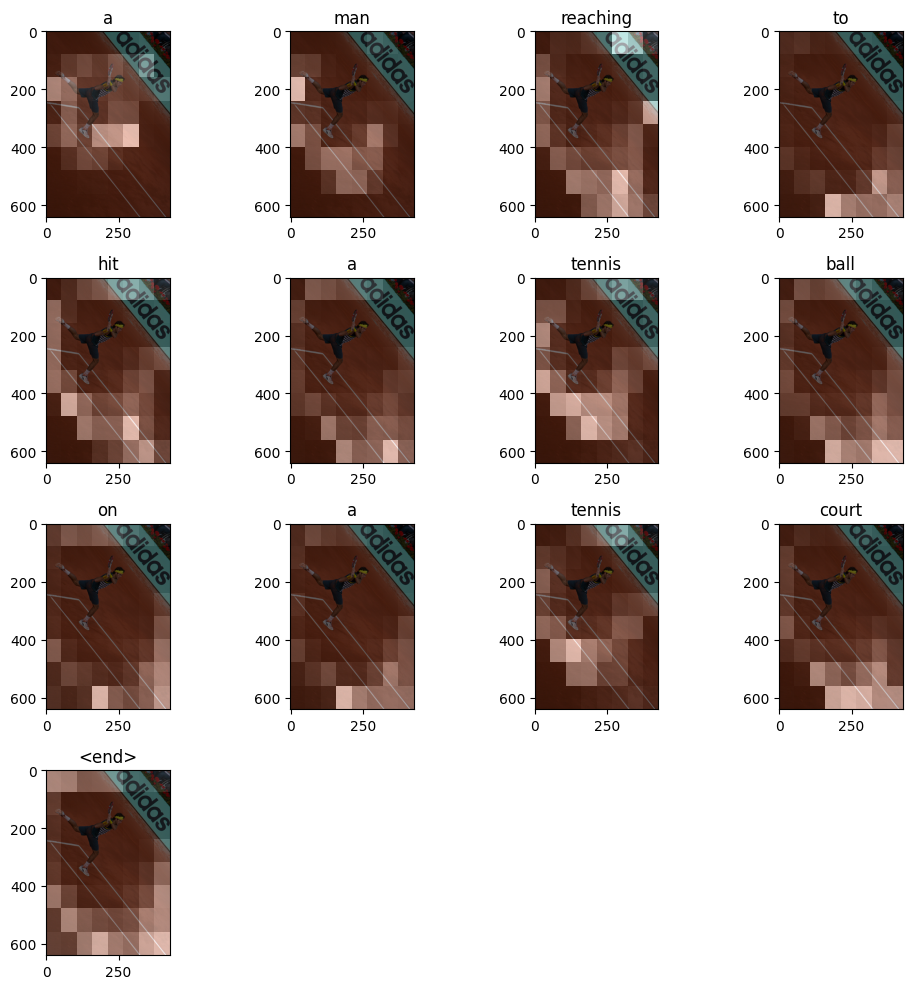

In [28]:
def display_random_annotation(img_name_val, cap_val, tokenizer, num_samples=1):
    for _ in range(num_samples):
        # Select a random index
        rid = np.random.randint(0, len(img_name_val))
        image = img_name_val[rid]

        # Generate the real caption by converting token IDs to words
        real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])

        # Predict the caption using the model
        result, attention_plot = evaluate(image)

        # Display the real and predicted captions
        print(f"\nImage ID: {rid}")
        print(f"Real Caption: {real_caption}")
        print(f"Prediction Caption: {' '.join(result)}")

        # Visualize the attention weights
        plot_attention(image, result, attention_plot)

# Call the function to display a random annotation
display_random_annotation(img_name_val, cap_val, tokenizer, num_samples=1)

## 5. Conclusion
Dans ce notebook, nous avons mis en œuvre un pipeline complet pour la **génération de légendes d'images** en utilisant des techniques avancées de **deep learning**. Le projet repose sur le dataset **COCO 2014**, qui associe des images à des légendes textuelles, et se concentre sur l'entraînement d'un modèle capable de générer des descriptions automatiques d'images.

Nous avons d'abord téléchargé et préparé les données en extrayant les images et leurs légendes associées. Les images ont été prétraitées à l'aide du modèle **InceptionV3**, un réseau de neurones convolutionnel pré-entraîné sur ImageNet. Ce modèle a servi à extraire des caractéristiques visuelles compactes et riches en informations. Ces caractéristiques ont ensuite été utilisées comme entrée dans le modèle de génération de légendes.

Le traitement des légendes a nécessité l'utilisation d'un **tokenizer** pour convertir les textes en séquences de tokens numériques exploitables par le modèle. Le vocabulaire a été limité aux `10 000` mots les plus fréquents, afin de conserver une taille de modèle gérable tout en capturant les informations sémantiques importantes. Les légendes ont également été complétées (padding) pour avoir une longueur uniforme, facilitant ainsi leur traitement en batchs lors de l'entraînement.

Ensuite, nous avons mis en place une architecture de type **Encoder-Décodeur** avec un **mécanisme d'attention Bahdanau**. L'encodeur, basé sur InceptionV3, a été utilisé pour transformer les images en vecteurs de caractéristiques. Le décodeur, une LSTM (Long Short-Term Memory), a ensuite pris ces vecteurs comme entrée pour générer les légendes séquentiellement, un mot à la fois. Le mécanisme d'attention a permis au modèle de se concentrer sur différentes parties de l'image à chaque étape de la génération, améliorant ainsi la qualité des légendes générées.

L'entraînement du modèle s'est déroulé sur `100` époques, avec une taille de batch de `32`. La fonction de perte utilisée était la **Sparse Categorical Crossentropy**, qui a permis de mesurer l'écart entre les légendes générées et les légendes réelles. L'optimiseur **Adam** a été employé pour ajuster les poids du modèle, garantissant une convergence efficace. Un système de **checkpoints** a également été mis en place pour sauvegarder régulièrement l'état du modèle, permettant de reprendre l'entraînement en cas d'interruption.

Une fois l'entraînement terminé, le modèle a été évalué sur des images non vues. La fonction `evaluate()` a été utilisée pour générer des légendes prédictives à partir de nouvelles images. Ces légendes ont été comparées aux légendes réelles afin de mesurer la performance du modèle. De plus, la fonction de visualisation des **poids d'attention** a permis de comprendre quelles parties de l'image le modèle considérait comme importantes lors de la génération de chaque mot.

Enfin, nous avons sauvegardé les poids du modèle et le tokenizer afin de permettre une **réutilisation** lors de l'inférence ou pour un éventuel nouvel entraînement. Cela garantit que les mêmes associations entre les mots et les indices sont utilisées, assurant ainsi la cohérence des légendes générées à partir de nouvelles images.

En résumé, ce projet a démontré l'efficacité d'un modèle **Encoder-Décodeur avec attention** pour la génération de légendes d'images. Ce type de modèle est essentiel pour des applications dans des domaines tels que la vision par ordinateur et le traitement du langage naturel. Les applications potentielles incluent des systèmes de description automatique d'images pour les personnes malvoyantes, des moteurs de recherche d'images basés sur les légendes générées, ou encore des assistants virtuels capables de comprendre et décrire des scènes visuelles.

Des **perspectives d'amélioration** existent, telles que l'exploration de modèles plus avancés comme les **Transformers**, ou l'augmentation du dataset pour améliorer la généralisation du modèle. En affinant le vocabulaire ou en ajustant les hyperparamètres, il est possible de rendre le modèle plus performant et de minimiser les erreurs dues aux mots inconnus. Ce projet constitue une base solide pour de futures explorations dans le domaine de la génération de légendes d'images et peut être étendu pour intégrer de nouvelles architectures ou de nouveaux cas d'usage.